# Setup

In [1]:
### Run environment setup
import os
import lib.BBSetup as BBSetup

### Define folders
base_folder = '..'
out_folder = BBSetup.set_folder(os.path.join(base_folder, 'Metrics', 'New'))

In [2]:
from functools import partial
from os.path import join, exists
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from tqdm import tqdm
#
from sklearn.metrics import classification_report as sklcls_report
from sklearn.metrics import f1_score, accuracy_score
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, TFAutoModelForCausalLM
#
from transformers import logging
logging.set_verbosity_info()
# only report errors
logging.set_verbosity(logging.CRITICAL)
#
# Import the metrics library
from lib.BBMetrics import BBMetric
# Pretty print module
import pprint
from lib.BBMetricResults import *
printer = pprint.PrettyPrinter(depth=4, width=300)
# Import project data
from lib.BBData import character_dict, model_name, random_state
from lib.BBDataLoad import load_char_df, get_chatbot_predictions

c:\Users\User\Documents\Unibo\NLP\BarneyBot\.env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
characters_folder = join(base_folder, "Data", "Characters")
print(characters_folder)
# takes the list of characters
characters = list(character_dict.keys())
# prepares the classification report
classification_report = partial(sklcls_report, target_names=characters)

..\Data\Characters


In [9]:
# function to shuffle 4 list and return just the last n
import random

def shuffle_lists(l1, l2, l3, l4, n):
    zipped = list(zip(l1, l2, l3, l4))
    random.shuffle(zipped)
    l1_shuffled, l2_shuffled, l3_shuffled, l4_shuffled = zip(*zipped)
    return list(l1_shuffled[:n]), list(l2_shuffled[:n]), list(l3_shuffled[:n]), list(l4_shuffled[:n])

# __Test Frequency Classifier cosine similarity over different number of lines__

Prepare the tokenizer and list of characters

In [4]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=join("..", "cache"))
tokenizer.pad_token = '#'

# get lists of characters
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')

Let's load the Frequency Chatbot Classifier and train the metric

In [5]:
# load the frequency chatbot classifier metric
metric = BBMetric.load_metric("frequency chatbot classifier")
print(metric)

{'name': 'frequency chatbot classifier', 'args': {'train': {'required': {'characters_path'}, 'optional': {'mode'}}, 'compute': {'required': {'sentences'}, 'optional': set()}}, 'returns': ['score', 'label'], 'save_actors': ['document'], 'pretty_name': 'Frequency Chatbot Classifier'}


In [6]:
# train the metric
metric.train(characters_path=os.path.join(base_folder, "Data","Characters"))

Loading data


100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Preprocessing data


100%|██████████| 9/9 [00:16<00:00,  1.84s/it]


Training model
Training done!


Initialize the test

In [13]:
### create dataset
n_tests = 20
# max number of lines for a single test on to pass to the Frequency classifier metric 
max_num_lines = 523
sampled_answers_ranges = [mnl for mnl in range(5, max_num_lines, 5)]

# select the chracter chatbot to test and an adversarial character 
character = 'Barney'
adversarial = 'Sheldon'

# get the indexes of character and adversarial character
c_id = characters.index(character)
adv_id = characters.index(adversarial)

# load the dataframes
character_hg = load_char_df(character, base_folder)
adversarial_hg = load_char_df(adversarial, base_folder)

# prepare the test history
chatbot_senteces = []
raw_predictions = []
test_history = {character: [{"n_sentences": ns,
                             "chatbot_senteces": [],
                             "real_senteces": [],
                             "adversarial_sentences":[],
                             "raw_chatbot_predictions": [],
                             "final_chatbot_prediction": [],
                             "raw_real_predictions": [],
                             "final_real_prediction": [],
                             "final_adversarial_prediction": []} for ns in sampled_answers_ranges]}

Using custom data configuration default-b8958b7fa2963b70
Found cached dataset csv (c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-b8958b7fa2963b70/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 68.10it/s]
Loading cached split indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-b8958b7fa2963b70/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-3bfe871a8a71fe40.arrow and c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-b8958b7fa2963b70/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-e593b080d5ac7f9a.arrow
Loading cached split indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-b8958b7fa2963b70/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-0f5b251134d22091.arrow and c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-b8958

Prepare chatbot predictions and script lines to test

In [8]:
# load adversarial predictions
adversarial_sampling = get_chatbot_predictions(
            None, None, character_dict[adversarial]['prediction_filename'] + '_sampling.json',
            "Sampling", adversarial, tokenizer, base_folder, override_predictions=False
        )
adversarial_responses = adversarial_hg['test']['response']
# load real character predictions
predictions_sampling = get_chatbot_predictions(
            None, None, character_dict[character]['prediction_filename'] + '_sampling.json',
            "Sampling", character, tokenizer, base_folder, override_predictions=False
        )
real_responses = character_hg['test']['response']
bot_responses =  [tokenizer.decode(j, skip_special_tokens=True) for j in predictions_sampling]
print(predictions_sampling[:5])
print(real_responses[:5])
print(bot_responses[:5])

Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
[[5812, 11, 1793, 11, 345, 821, 8066, 307, 287, 326, 530, 13, 50256], [464, 19145, 1894, 850, 13, 50256], [40, 1444, 1115, 6334, 8213, 284, 1037, 502, 651, 503, 286, 262, 7962, 13, 50256], [2437, 881, 1257, 318, 428, 30, 50256], [2504, 338, 340, 30, 921, 821, 852, 41921, 338, 1266, 1545, 30, 50256]]
["Daddy's home.", "I don't have much time!", "I could tell you knew something was up with me, and you're right. But I can't tell you what it is. I should tell you, but I can't! I have to. I never will! I'm going to. Let's just drop it. What's up with you?", 'A little.', "I'm being Barney, and I think tonight's going to be de... wait for it... lightful. Delightful."]
["Oh, God, you're gonna be in that one.", 'The Meatball sub.', 'I called three emergency personnel to help me get out of the apartment.', 'How much fun is this?', "That's it? You're be

In [10]:
# repeat the test n_tests time
for t in tqdm(range(n_tests)):
    for ns, i in zip(sampled_answers_ranges, range(len(sampled_answers_ranges))):
        # Sampling generation method
        pshuffle, rshuffle, bshuffle, ashuffle = shuffle_lists(predictions_sampling, real_responses, bot_responses, adversarial_responses, ns)
        test_history[character][i]["real_senteces"].append(rshuffle)
        test_history[character][i]["adversarial_sentences"].append(ashuffle)
        test_history[character][i]["chatbot_senteces"].append(bshuffle)
        test_history[character][i]["raw_chatbot_predictions"].append(list(metric.compute(sentences=bshuffle)['score']))
        test_history[character][i]["raw_real_predictions"].append(list(metric.compute(sentences=rshuffle)['score']))
        test_history[character][i]["final_chatbot_prediction"].append(list(metric.compute(sentences=bshuffle)['score'])[c_id])
        test_history[character][i]["final_real_prediction"].append(list(metric.compute(sentences=rshuffle)['score'])[c_id])
        test_history[character][i]["final_adversarial_prediction"].append(list(metric.compute(sentences=ashuffle)['score'])[adv_id])

100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


In [11]:
# number of sentences per test
x = [t['n_sentences'] for t in test_history[character]]
# chatbot character prediction 
y_bot = [np.mean(t['final_chatbot_prediction']) for t in test_history[character]]
std_bot = np.array([np.std(t['final_chatbot_prediction']) for t in test_history[character]])
# labels character prediction 
y_real = [np.mean(t['final_real_prediction']) for t in test_history[character]]
std_real = np.array([np.std(t['final_real_prediction']) for t in test_history[character]])
# labels adversarial prediction 
y_adv = [np.mean(t['final_adversarial_prediction']) for t in test_history[character]]
std_adv = np.array([np.std(t['final_adversarial_prediction']) for t in test_history[character]])

Mean and standard deviation of cosine similarity of cTFIDF, trained on Barney, computed on other Barney labels, on Sheldon labels and on the Barney chatbot. Obviously, the similarity is higher when considering Barney w.r.t Sheldon chatbot, both for labels and chatbots. However, as the number of sentences increases, the Barney and Sheldon chatbots reach similar performances, a worrying sign of overfitting

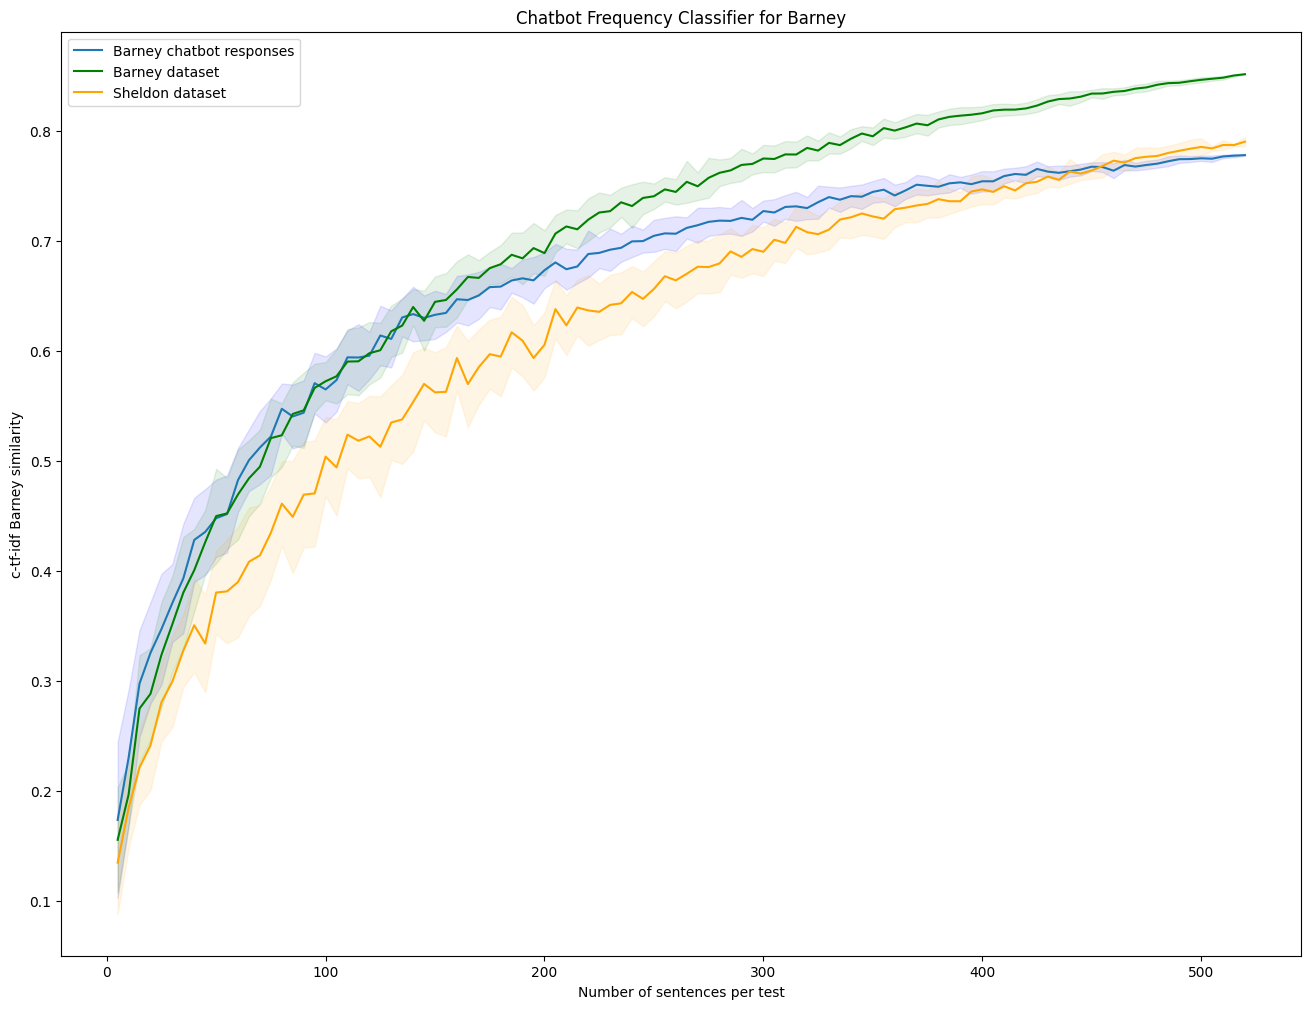

In [12]:
fig, ax = plt.subplots(figsize=(16,12))
ax.set_xlabel('Number of sentences per test')
ax.set_ylabel('c-tf-idf '+character+' similarity')
ax.set_title('Chatbot Frequency Classifier for '+character)
# chatbot character prediction
ax.plot(x, y_bot, label=character+' chatbot responses')
ax.fill_between(x, (y_bot-std_bot), (y_bot+std_bot), color='b', alpha=.1)
# labels character prediction 
ax.plot(x, y_real, label=character+' dataset', color='g')
ax.fill_between(x, (y_real-std_real), (y_real+std_real), color='green', alpha=.1)
# labels adversarial prediction 
ax.plot(x, y_adv, label=adversarial+' dataset', color='orange')
ax.fill_between(x, (y_adv-std_adv), (y_adv+std_adv), color='orange', alpha=.1)

ax.legend(loc='best')
# plt.savefig(join(base_folder, 'src', character+'_cTFIDF.png'))
plt.show()